# Interpretable Patches - Vu

- This tutorial attempts to find wounding related genes using only the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.


- Throughout this tutorial, we will use the workflow package with Patches to find genes that are associated with the 4DPW timepoint. 

In [1]:
# Minimal mports
from ladder.data import get_data
from ladder.scripts import InterpretableWorkflow # Our workflow object to run the interpretable model
import umap, torch, pyro, os # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For data loading
import anndata as ad
import scanpy as sc

## Formatting The Data

The workflows use [anndata](https://anndata.readthedocs.io/en/latest/) objects as input. Specifically, the data we provide can also be manually downloaded [here](https://drive.google.com/file/d/1quCP3403hOPG5Q8cy1KWZui_a0mJrQ5J/view?usp=drive_link). 

In [2]:
# Download the data object
get_data("Vu") 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292M/292M [00:02<00:00, 116MB/s]

Object saved at ./data/vu_2022_ay_wh.h5ad


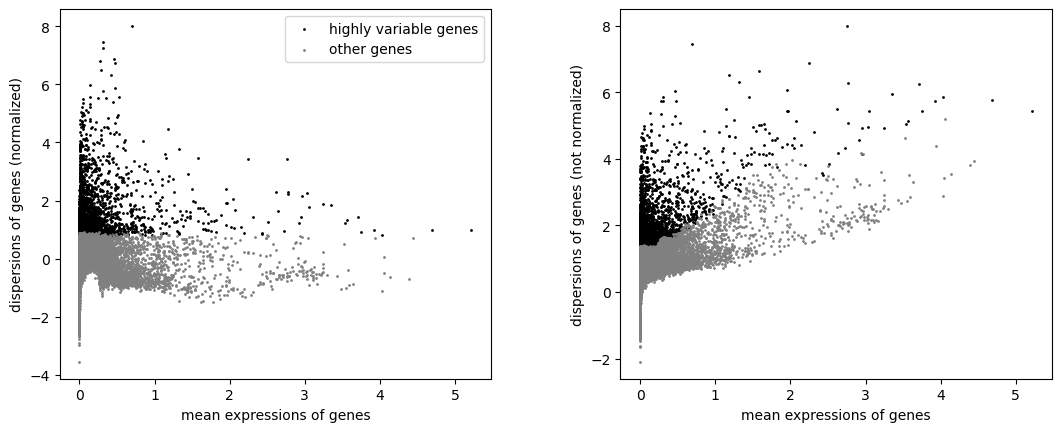

In [3]:
# Load the anndata object
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")
anndata.layers["normalized"] = anndata.X

# Find/subset HVGs & swap to raw counts
sc.pp.highly_variable_genes(anndata, n_top_genes=3000, batch_key="sample")
sc.pl.highly_variable_genes(anndata)

anndata = anndata[:, anndata.var["highly_variable"]]
anndata.X = anndata.layers["counts"]

In [4]:
anndata

View of AnnData object with n_obs × n_vars = 26966 × 3000
    obs: 'age', 'time', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'broad_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'broad_type_colors', 'dendrogram_broad_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_gr

## Initializing the Interpretable Workflow
- Models can be run through two workflow interfaces: **InterpretableWorkflow** and **CrossConditionWorkflow** (see the corresponding [tutorial](crossconditional_vu_tutorial.ipynb))

- Once initialized, you can train and evaluate the model through the workflow interface. 

In [ ]:
# Initialize workflow object
workflow = InterpretableWorkflow(anndata, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "age", "broad_type"]
workflow.prep_model(factors, batch_key="sample", model_type='Patches', model_args={'ld_normalize' : True})

workflow.run_model(max_epochs=1000, convergence_threshold=1e-5, convergence_window=1000) # Lower the convergence threshold if you need a more accurate model, will increase training time
workflow.save_model("params/vu_ld")

## Observing the Losses

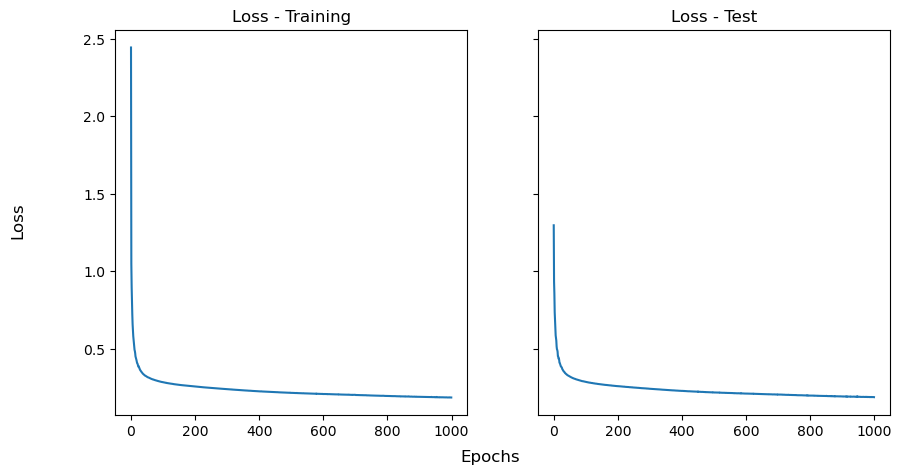

In [6]:
workflow.plot_loss()

## Obtaining Latent Embeddings

In [7]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: X_pca, X_umap, patches_w_latent, patches_z_latent

## Evaluation of Model Reconstruction

In [8]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.50s/it]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.50s/it]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.36s/it]


Calculating Chamfer Discrepancy ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.30it/s]

Results
RMSE : 8.685 +- 0.311
Profile Correlation : 0.962 +- 0.0
2-Sliced Wasserstein : 9.368 +- 0.701
Chamfer Discrepancy : 121.983 +- 38.043


{'RMSE': [8.685, 0.311],
 'Profile Correlation': [0.962, 0.0],
 '2-Sliced Wasserstein': [9.368, 0.701],
 'Chamfer Discrepancy': [121.983, 38.043]}

## Interpretability - Common and Conditional Gene Loadings

- Patches can generate condition-specific scores for each gene, describing the association of the gene and the condition, even if the conditions were always encountered combinatorially.

- Positive/Negative values mean that the given gene tends to be expressed relatively more/less for that condition compared to the basal state.

In [9]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,...,Fibroblast_score_Patches,Granulocyte_score_Patches,Keratinocyte_score_Patches,Macrophage_score_Patches,Melanocyte_score_Patches,Neutrophil_score_Patches,Pericyte_score_Patches,Skeletal Muscle_score_Patches,T Cell_score_Patches,common_score_Patches
Sox17,False,False,False,447,0.025372,0.025055,99.026504,1165.0,7.061335,True,...,-0.172691,-0.213733,-0.064396,-0.231657,0.060180,-0.209632,-0.115450,0.081388,-0.108086,0.096553
Prex2,False,False,False,4967,0.223730,0.201903,89.182656,10273.0,9.237371,True,...,0.317856,-0.011027,-0.074715,-0.212266,0.028524,-0.037938,-0.004642,-0.077855,0.037797,0.032534
Slco5a1,False,False,False,1513,0.055491,0.054006,96.704924,2548.0,7.843456,True,...,0.222914,0.036253,0.057877,0.100015,-0.198793,0.147040,-0.023676,-0.251914,0.016166,0.692136
Jph1,False,False,False,852,0.020994,0.020777,98.144478,964.0,6.872128,True,...,0.172165,-0.114392,0.103020,-0.072656,0.072942,0.184129,-0.068458,0.068210,-0.286386,0.446361
Pi15,False,False,False,3381,0.195069,0.178204,92.636714,8957.0,9.100303,True,...,0.373721,-0.020328,0.234529,0.174611,0.064675,-0.166265,0.210245,-0.003035,-0.071886,0.256239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nrap,False,False,False,455,0.023325,0.023057,99.009082,1071.0,6.977282,True,...,-0.071591,0.169128,-0.172085,-0.043409,-0.007615,0.065033,0.030125,0.064808,-0.013635,-0.142112
Slc18a2,False,False,False,268,0.010279,0.010227,99.416338,472.0,6.159095,True,...,-0.054472,0.004801,0.046696,-0.108449,0.107959,-0.108925,0.136082,0.107105,-0.030343,-0.011968
Csf2ra,False,False,False,8080,0.353791,0.302908,82.403032,16245.0,9.695602,True,...,-0.031811,-0.172225,-0.039741,0.132805,0.180531,0.028858,-0.052445,0.145707,-0.058978,0.067027
AC133103.1,False,False,False,114,0.002962,0.002957,99.751726,136.0,4.919981,True,...,-0.181475,0.000465,-0.020807,0.096036,-0.083226,0.044714,-0.031599,-0.170607,0.073240,0.330647


## Bonus

1. Run the cell below to get the top 200 genes
2. Copy & Paste the output to the [Gene Ontology Resource](https://geneontology.org/)
3. Select 'biological process' and 'Mus Musculus' from the list below and click launch.

In [11]:
for gene in (workflow.anndata.var["Fibroblast_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene)

Dcn
Col1a2
Col1a1
Col3a1
Igfbp2
Sparc
Mfap4
Cpxm1
Gsn
Tnfaip6
Cilp
Serpina3n
Cpz
Efemp1
Tnc
Ogn
Sfrp2
Cxcl13
Scara5
Eln
Mmp3
Gpx3
Tnmd
Pi16
Ptx3
Postn
Cthrc1
Cyp26b1
Cyp2f2
Nov
Igfbp6
Saa3
Fmod
Fibin
Has1
Thbs4
Prg4
Lox
C1qtnf3
Peg3
Sfrp4
Col14a1
Gfpt2
Lbp
Stc1
Timp1
Rxfp1
Mme
Ugdh
C4b
Hmcn2
Igfbp4
Mfap5
Adamtsl2
C3
Cyr61
Itm2a
Pcsk5
Prss35
Tnn
Slc26a7
Col12a1
Plod2
Gas1
Pla1a
Adamts5
Aspn
Fbln7
Gdf10
Smpd3
Meg3
Col11a1
Chodl
Gldn
Coch
Grem1
Tgfb2
Gm16685
Dkk2
Mmp11
Apod
Myoc
Gpc3
Sned1
Cxcl12
Igf1
Ace
Cdkn2a
Scube3
Tctn1
Col8a1
Stmn2
Ptgis
Sfrp1
Cxcl5
Smoc2
Ndnf
Cdkn1c
Cp
Inmt
Col7a1
F13a1
Itih5
Wfdc12
Abca8a
Ccl19
Hgf
Itga2b
Col5a3
Ackr3
Ccl11
Ccl2
Timp3
Serpine1
Fgl2
Atp1a2
Efhd1
Il1r2
Csrp2
Ednrb
Slco2b1
Matn4
Lrrc15
Dnm3
Lgr5
Gbp2
Iigp1
Tmem158
Bmp4
Lepr
Notum
Gm12840
Cxcl9
Cygb
Pmp22
Dnm3os
Vwa5a
Hp
Rorb
F2r
Adm
Gpha2
Nol3
Rtn2
F830016B08Rik
Serpinb2
Sox11
Fam198b
Vamp5
Mapk12
Gatm
Nrep
Igtp
Nos2
1500015O10Rik
Plac8
Acan
Ccl7
Ifi205
Ptch1
Spp1
Depdc5
Pfn2
Col23a1
Tac1
Crabp1
Cris